Création de bruit de différents types

In [24]:
import numpy as np
import os
import cv2
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

In [25]:
import matplotlib.pyplot as plt

my_img = cv2.imread('test_2.png')
cv2.imwrite('test_2_bruit_2.png',
            noisy("gauss",my_img))

True

In [3]:
import random
import cv2
 
def add_noise(img):
 
    # Getting the dimensions of the image
    row , col = img.shape
     
    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to white
        img[y_coord][x_coord] = 255
         
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to black
        img[y_coord][x_coord] = 0
         
    return img
 
# salt-and-pepper noise can
# be applied only to grayscale images
# Reading the color image in grayscale image
img = cv2.imread('test_2.png',
                 cv2.IMREAD_GRAYSCALE)
 
#Storing the image
cv2.imwrite('test_2_bruit.png',
            add_noise(img))

True

Filtre gaussien et médian + hist equi

41.004375650778265
33.43541433161048


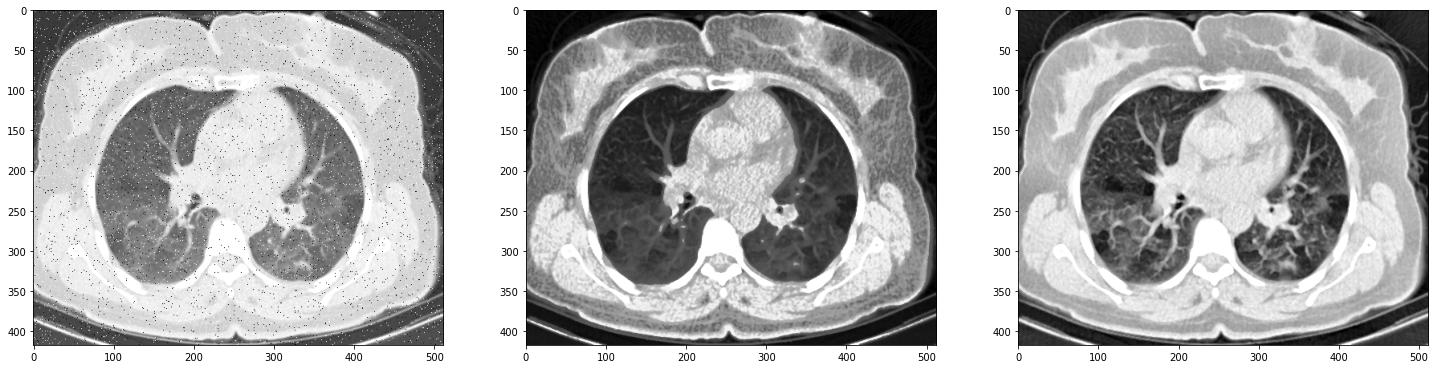

In [44]:
import cv2
import numpy as np
from IPython.display import display, Math, Latex
from math import log10, sqrt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as PSNR

my_img = cv2.imread('test_3_bruit.png',0)
original=cv2.imread('test_3.png',0)

median = cv2.medianBlur(my_img, 3)
gauss = cv2.GaussianBlur(my_img, (5,5), 0)

       
print(PSNR(original,median))
print(PSNR(original,gauss))


"""
original = my_img.copy()
xp = [0, 64, 128, 192, 255]
fp = [0, 16, 128, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')
img = cv2.LUT(gauss, table)
cv2.imshow("original", original)
cv2.imshow("Output", img)
cv2.waitKey(0)
cv2.destroyAllWindows() 
"""

img1 = np.asarray(median)

# put pixels in a 1D array by flattening out img array
flat = img1.flatten()

# show the histogram
#plt.hist(flat, bins=50)

def get_histogram(image, bins):
    # array with size of bins, set to zeros
    histogram = np.zeros(bins)
    
    # loop through pixels and sum up counts of pixels
    for pixel in image:
        histogram[pixel] += 1
    
    # return our final result
    return histogram

# execute our histogram function
hist = get_histogram(flat, 256)

def cumsum(a):
    a = iter(a)
    b = [next(a)]
    for i in a:
        b.append(b[-1] + i)
    return np.array(b)

# execute the fn
cs = cumsum(hist)

# display the result
#plt.plot(cs)

# numerator & denomenator
nj = (cs - cs.min()) * 255
N = cs.max() - cs.min()

# re-normalize the cumsum
cs = nj / N

# cast it back to uint8 since we can't use floating point values in images
cs = cs.astype('uint8')

#plt.plot(cs)

img_new = cs[flat]

# put array back into original shape since we flattened it
img_new = np.reshape(img_new, img1.shape)

# set up side-by-side image display
fig = plt.figure()
fig.set_figheight(25)
fig.set_figwidth(25)


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  #Define tile size and clip limit. 
cl1 = clahe.apply(median)


fig.add_subplot(1,3,1)
plt.imshow(my_img, cmap='gray')

# display the new image
fig.add_subplot(1,3,2)
plt.imshow(img_new, cmap='gray')

fig.add_subplot(1,3,3)
plt.imshow(cl1, cmap='gray')

plt.show(block=True)


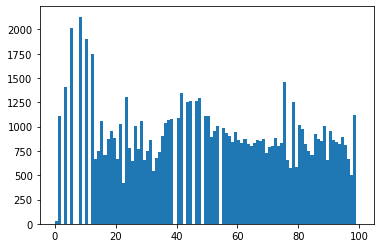

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


img = cv2.imread('test_3_bruit_2.png',0)

median = cv2.medianBlur(img, 3)
gauss = cv2.GaussianBlur(img, (5,5), 0)
equ = cv2.equalizeHist(median)

plt.hist(equ.flat, bins=100, range=(0,100))

cv2.imshow("Original Image", img)
cv2.imshow("Equalized", equ)

#Together the algorithm is called: Contrast Limited Adaptive Histogram Equalization (CLAHE)

# Start by creating a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  #Define tile size and clip limit. 
cl1 = clahe.apply(median)

cv2.imshow("CLAHE", cl1)

cv2.waitKey(0)          
cv2.destroyAllWindows() 




Text(0.5, 1.0, 'NLfastMean\n RMSE : 1.9444631493793496\n PSNR : 42.35480926865574\n SSIM : 0.9608799832414957')

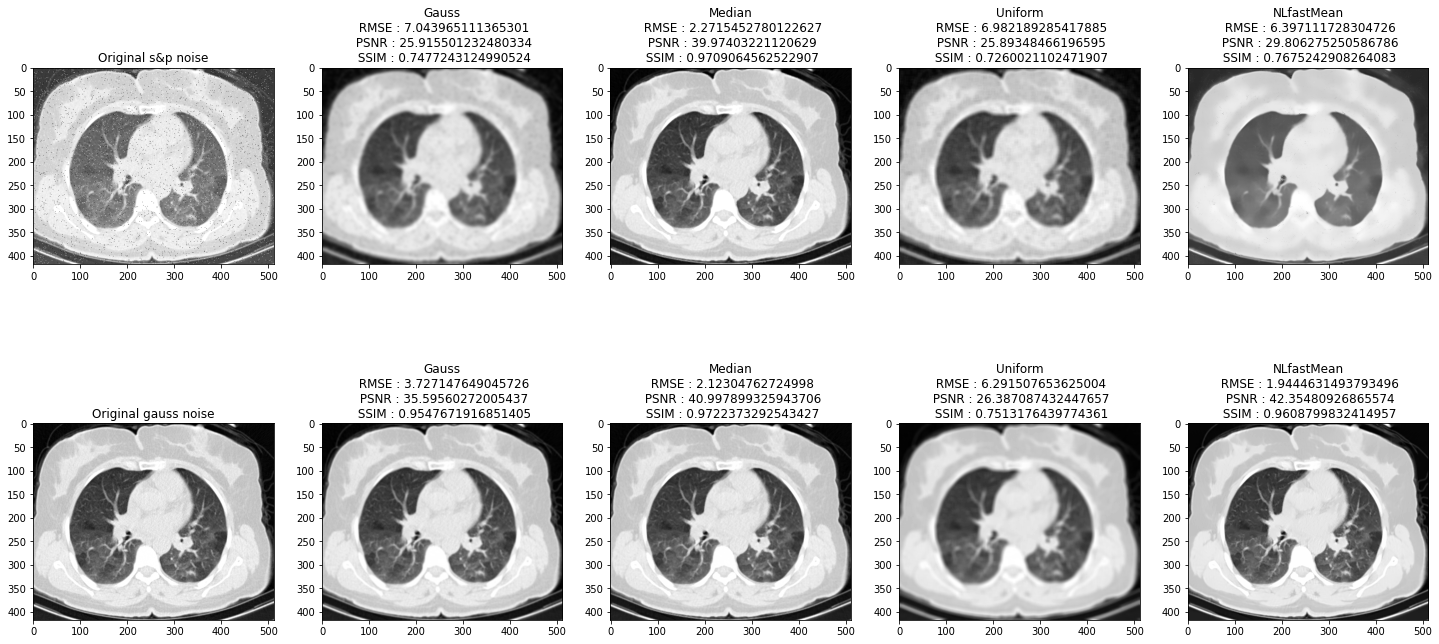

In [93]:
from pickle import TRUE
from turtle import title
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as PSNR

def RMSE(imageA, imageB):
    diffrnce = np.subtract(imageA, imageB)
    sqre_err = np.square(diffrnce)
    rslt_meansqre_err = sqre_err.mean()
    root_meansqre_err = math.sqrt(rslt_meansqre_err)
    return root_meansqre_err

img1 = cv2.imread("test_3_bruit.png", 0)
img2 = cv2.imread("test_3_bruit_2.png", 0)
original=cv2.imread("test_3.png", 0)

uniform_filtered_img1 = ndimage.uniform_filter(img1, size=9)
uniform_filtered_img2 = ndimage.uniform_filter(img2, size=9)

blurred_img1 = ndimage.gaussian_filter(img1, sigma=3)  
blurred_img2 = ndimage.gaussian_filter(img2, sigma=1)

median_img1 = ndimage.median_filter(img1, 3)
median_img2 = ndimage.median_filter(img2, 3)

dst1 = cv2.fastNlMeansDenoising(img1, h=31, templateWindowSize=7)
dst2 = cv2.fastNlMeansDenoising(img2, h=3, templateWindowSize=7)

RMSE_gauss1=RMSE(original, blurred_img1)
RMSE_gauss2=RMSE(original, blurred_img2)

RMSE_med1=RMSE(original, median_img1)
RMSE_med2=RMSE(original, median_img2)

RMSE_uni1=RMSE(original, uniform_filtered_img1)
RMSE_uni2=RMSE(original, uniform_filtered_img2)

RMSE_dst1=RMSE(original, dst1)
RMSE_dst2=RMSE(original, dst2)

ssim_gauss1=ssim(original,blurred_img1)
ssim_gauss2=ssim(original,blurred_img2)

ssim_med1=ssim(original,median_img1)
ssim_med2=ssim(original,median_img2)

ssim_uni1=ssim(original,uniform_filtered_img1)
ssim_uni2=ssim(original,uniform_filtered_img2)

ssim_dst1=ssim(original,dst1)
ssim_dst2=ssim(original,dst2)

# set up side-by-side image display
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(25)

fig.add_subplot(2,5,1)
plt.imshow(img1, cmap='gray')
plt.title('Original s&p noise')

fig.add_subplot(2,5,2)
plt.imshow(blurred_img1, cmap='gray')
plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss1,PSNR(original,blurred_img1),ssim_gauss1))

fig.add_subplot(2,5,3)
plt.imshow(median_img1, cmap='gray')
plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med1,PSNR(original,median_img1),ssim_med1))

fig.add_subplot(2,5,4)
plt.imshow(uniform_filtered_img1, cmap='gray')
plt.title("Uniform\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_uni1,PSNR(original,uniform_filtered_img1),ssim_uni1))

fig.add_subplot(2,5,5)
plt.imshow(dst1, cmap='gray')
plt.title("NLfastMean\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_dst1,PSNR(original,dst1),ssim_dst1))

fig.add_subplot(2,5,6)
plt.imshow(img2, cmap='gray')
plt.title('Original gauss noise')

fig.add_subplot(2,5,7)
plt.imshow(blurred_img2, cmap='gray')
plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss2,PSNR(original,blurred_img2),ssim_gauss2))

fig.add_subplot(2,5,8)
plt.imshow(median_img2, cmap='gray')
plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med2,PSNR(original,median_img2),ssim_med2))

fig.add_subplot(2,5,9)
plt.imshow(uniform_filtered_img2, cmap='gray')
plt.title("Uniform\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_uni2,PSNR(original,uniform_filtered_img2),ssim_uni2))

fig.add_subplot(2,5,10)
plt.imshow(dst2, cmap='gray')
plt.title("NLfastMean\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_dst2,PSNR(original,dst2),ssim_dst2))


In [75]:
import numpy as np
import PyWavelets as pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt

img=cv2.imread('test_3_bruit.png',0)
original=cv2.imread('test_3.png',0)

y = denoise_wavelet(img, wavelet='db1', mode='soft', wavelet_levels=2, method='BayesShrink', rescale_sigma='True')
plt.imshow(y)
plt.show()

ModuleNotFoundError: No module named 'PyWavelets'